# RF vs MERF

This notebook contains comparison of Random Forest vs. MERF models on [Rossman Kaggle competetion](https://www.kaggle.com/c/rossmann-store-sales) dataset. The feature engineering steps are borrowed from 3rd place holder in the competetion and codes are taken from fast.ai DL1 course [notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson3-rossman.ipynb). We are not using entity embedddings steps are shown in the notebook as our goal is just to compare RF and MERF for now. The solution is using external data (weather and googletrend), we are not going to use that too for our purpose

## Goal of the problem

Predict NEXT six weeks out. N+1 all the way to N+(7x6) days. 

In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany.

## Libraries

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import re
sys.path.append('..')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from IPython.display import HTML, display
import matplotlib.pyplot as plt
from merf.merf import MERF
from sklearn.model_selection import train_test_split
from merf.evaluator import plot_bhat, plot_training_stats

In [3]:
pd.options.display.float_format = '{:.2f}'.format

## Data

In [4]:
train = pd.read_csv('../data/kaggle_train.csv')
test = pd.read_csv('../data/kaggle_test.csv')
store = pd.read_csv('../data/kaggle_store.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Feature Space:

* train: Contains store information on a daily basis, tracks things like sales, customers, whether that day was a holdiay, etc.
* store: general info about the store including competition, etc.
* test: Same as training table, w/o sales and customers

In [5]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.00,1,0,0
1,2,3,4,2015-09-17,1.00,1,0,0
2,3,7,4,2015-09-17,1.00,1,0,0
3,4,8,4,2015-09-17,1.00,1,0,0
4,5,9,4,2015-09-17,1.00,1,0,0


In [7]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.00,9.00,2008.00,0,nan,nan,NaN
1,2,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,c,c,620.00,9.00,2009.00,0,nan,nan,NaN
4,5,a,a,29910.00,4.00,2015.00,0,nan,nan,NaN


In [8]:
# There are 1115 Stores
train['Store'].unique()

array([   1,    2,    3, ..., 1113, 1114, 1115])

In [9]:
train.shape, store.shape,test.shape

((1017209, 9), (1115, 10), (41088, 8))

Data is in descending order based on date

In [10]:
test[test['Store'] == 1].head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.00,1,0,0
856,857,1,3,2015-09-16,1.00,1,0,0
1712,1713,1,2,2015-09-15,1.00,1,0,0
2568,2569,1,1,2015-09-14,1.00,1,0,0
3424,3425,1,7,2015-09-13,0.00,0,0,0


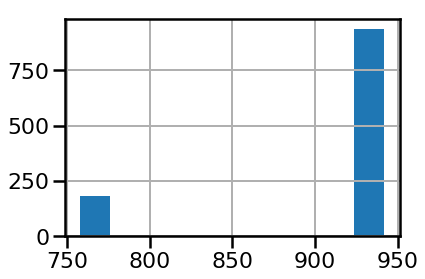

In [11]:
h = train.groupby('Store').count()['Sales'].hist()

So, we have either ~760 days or ~930 days of data for all the stores


In [12]:
tables = [train, store, test]

In [13]:
# data types
for t in tables: print(t.dtypes, '\n')

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object 

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object 

Id                 int64
Store              int64
DayOfWeek          int64
Date              object
Open             float64
Promo              int64
StateHoliday      object
SchoolHoliday      int64
dtype: object 



In [14]:
# summaries
for t in tables: display(t.describe())

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00
mean,558.43,4.00,5773.82,633.15,0.83,0.38,0.18
std,321.91,2.00,3849.93,464.41,0.38,0.49,0.38
min,1.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,280.00,2.00,3727.00,405.00,1.00,0.00,0.00
50%,558.00,4.00,5744.00,609.00,1.00,0.00,0.00
75%,838.00,6.00,7856.00,837.00,1.00,1.00,0.00
max,1115.00,7.00,41551.00,7388.00,1.00,1.00,1.00


,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00,1112.00,761.00,761.00,1115.00,571.00,571.00
mean,558.00,5404.90,7.22,2008.67,0.51,23.60,2011.76
std,322.02,7663.17,3.21,6.20,0.50,14.14,1.67
min,1.00,20.00,1.00,1900.00,0.00,1.00,2009.00
25%,279.50,717.50,4.00,2006.00,0.00,13.00,2011.00
50%,558.00,2325.00,8.00,2010.00,1.00,22.00,2012.00
75%,836.50,6882.50,10.00,2013.00,1.00,37.00,2013.00
max,1115.00,75860.00,12.00,2015.00,1.00,50.00,2015.00


,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
count,41088.00,41088.00,41088.00,41077.00,41088.00,41088.00
mean,20544.50,555.90,3.98,0.85,0.40,0.44
std,11861.23,320.27,2.02,0.35,0.49,0.50
min,1.00,1.00,1.00,0.00,0.00,0.00
25%,10272.75,279.75,2.00,1.00,0.00,0.00
50%,20544.50,553.50,4.00,1.00,0.00,0.00
75%,30816.25,832.25,6.00,1.00,1.00,1.00
max,41088.00,1115.00,7.00,1.00,1.00,1.00


## Data preparation for modeling/ Feature engineering
codes borrowed from - https://github.com/fastai/fastai/blob/master/courses/dl1/lesson3-rossman.ipynb

#### 1: datepart features

We turn state Holidays to booleans, to make them more convenient for modeling. We can do calculations on pandas fields using notation very similar (often identical) to numpy.

In [15]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

In [16]:
def add_datepart(df, fldname, drop=True, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [17]:
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

#### 2: joining stores

Now we can outer join all of our data into a single dataframe. Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

Aside: Why note just do an inner join? If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [18]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

In [19]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [20]:
joined_test.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Year', 'Month', 'Week', 'Day', 'Dayofweek',
       'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
       'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

#### 3: missing values

In [21]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

Replacing null month and week with 1, not 0 because 0 is not recognizable as any date in pandas and we have used this data to make more features as shown in #4

#### 4: Competetion open features

Next we'll extract features "CompetitionOpenSince" and "CompetitionDaysOpen". Note the use of apply() in mapping a function across dataframe values.

In [22]:
joined.filter(like = 'Competition', axis=1)[:2]

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear
0,1270.00,9,2008
1,570.00,11,2007


In [23]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

#### 5: We'll replace some erroneous / outlying data.

In [24]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

#### 6: add "CompetitionMonthsOpen" field, limiting the maximum to 2 years to limit number of unique categories.

In [25]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,
        1, 14, 20,  8, 18,  6, 21,  5])

#### 7: processing promo dates

In [26]:
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.Promo2SinceWeek.astype(str)+
                                       df.Promo2SinceYear.astype(str).add('-0'),
                                       format='%W%Y-%w')
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [27]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

#### 8: cat codes

In [28]:
joined.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'CompetitionDaysOpen', 'CompetitionMonthsOpen',
       'Promo2Since', 'Promo2Days', 'Promo2Weeks'],
      dtype='object')

In [29]:
cat_vars = ['Store', 
            'DayOfWeek',
            'Year',
            'Month', 
            'Day',
            'StateHoliday',
            'CompetitionMonthsOpen',
            'Promo2Weeks',
            'StoreType', 
            'Assortment', 
            'PromoInterval', 
            'CompetitionOpenSinceYear',
            'Promo2SinceYear', 
            'Week']

contin_vars = ['CompetitionDistance',
               'Promo',
               'SchoolHoliday']

n = len(joined); n

1017209

In [30]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [31]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

In [32]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [33]:
def apply_cats(df, trn):
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)
            df[n] = df[n].cat.codes

In [34]:
apply_cats(joined_test, joined)

In [35]:
for col in joined.columns:
    if joined[col].dtype.name=='category':
        joined[col] = joined[col].cat.codes

In [36]:
for v in contin_vars:
    joined[v] = joined[v].fillna(0).astype('float32')
    joined_test[v] = joined_test[v].fillna(0).astype('float32')

In [37]:
n = 5000
joined_samp = joined.sample(n).set_index("Date")
samp_size = len(joined_samp); samp_size

5000

In [38]:
joined_samp = joined_samp[joined_samp.Sales!=0]

In [39]:
joined_samp.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,Week,CompetitionDistance,Promo,SchoolHoliday,Sales
Date,,,,,,,,,,,,,,,,,,
2014-06-11,616,2,1,5,10,0,0,25,0,2,1,0,3,23,8940.00,0.00,0.00,6002
2013-09-02,999,0,0,8,1,0,24,0,0,2,1,16,6,35,2230.00,0.00,1.00,6555


In [40]:
y = joined_samp['Sales']

In [41]:
df = joined_samp.drop(labels='Sales',axis=1)

In [42]:
df.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,Week,CompetitionDistance,Promo,SchoolHoliday
Date,,,,,,,,,,,,,,,,,
2014-06-11,616,2,1,5,10,0,0,25,0,2,1,0,3,23,8940.00,0.00,0.00
2013-09-02,999,0,0,8,1,0,24,0,0,2,1,16,6,35,2230.00,0.00,1.00


## Data split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.20, random_state=42)

## RF

In [62]:
model = RandomForestRegressor(n_jobs=-1, oob_score=True, n_estimators=300)

In [63]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [64]:
from sklearn.metrics import mean_squared_error
import math

In [65]:
def rmspe(targ, y_pred):
    pct_var = (targ - y_pred)/targ
    return math.sqrt((pct_var**2).mean())

In [66]:
preds = model.predict(X_test)
model.score(X_train, y_train), model.score(X_test, y_test), model.oob_score_, rmspe(y_test, preds)

(0.9162744434472276,
 0.41505970017544747,
 0.3867377232935828,
 0.45288873276152364)

## MERF

In [49]:
X_train.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,Week,CompetitionDistance,Promo,SchoolHoliday
Date,,,,,,,,,,,,,,,,,
2015-06-15,144,0,2,5,14,0,0,25,0,0,0,0,1,24,280.00,1.00,0.00
2014-09-09,905,1,1,8,8,1,24,0,0,0,-1,17,0,36,90.00,0.00,0.00


In [50]:
from merf import MERF

In [51]:
merf = MERF()

Covariates with possible random effect:  
* Store
* StoreType

In [52]:
clusters_train = X_train['Store']

In [53]:
X_train_merf = X_train.drop(['Store'],axis=1)

In [54]:
Z_train = np.ones(shape=(X_train.shape[0],1))

In [55]:
merf.fit(X_train, Z_train, clusters_train, y_train)

INFO     [merf.py:242] GLL is 67835.44945731787 at iteration 1.
INFO     [merf.py:242] GLL is 67322.44273520685 at iteration 2.
INFO     [merf.py:242] GLL is 67215.39260860701 at iteration 3.
INFO     [merf.py:242] GLL is 67073.83020548563 at iteration 4.
INFO     [merf.py:242] GLL is 67054.59108798085 at iteration 5.
INFO     [merf.py:242] GLL is 67070.57119202032 at iteration 6.
INFO     [merf.py:242] GLL is 67045.88431476978 at iteration 7.
INFO     [merf.py:242] GLL is 66998.77347094001 at iteration 8.
INFO     [merf.py:242] GLL is 66991.02011568633 at iteration 9.
INFO     [merf.py:242] GLL is 66978.46901454128 at iteration 10.
INFO     [merf.py:242] GLL is 66978.68528052924 at iteration 11.
INFO     [merf.py:242] GLL is 66973.4107484582 at iteration 12.
INFO     [merf.py:242] GLL is 66989.35167693514 at iteration 13.
INFO     [merf.py:242] GLL is 66980.5656190722 at iteration 14.
INFO     [merf.py:242] GLL is 66998.87419162733 at iteration 15.
INFO     [merf.py:242] GLL is 66987.

Predictions

In [59]:
clusters_test = X_test['Store']
X_test_merf = X_test.drop(['Store'],axis=1)
Z_test = np.ones(shape=(X_test.shape[0],1))

In [60]:
y_hat = merf.predict(X_test, Z_test, clusters_test)

In [61]:
rmspe(y_hat, preds)

0.3188066598400565

Keeping everything else same, MERF gave lower RMSPE than RF

### End